In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. Creating TikTak player

In [136]:
class PacardoPlayer:
    """
        defines simple AI player
        @constructors:
            __init__(self, player_name, symbol = 1, exp_rate=0.3) - creates PacardoPlayer object
        @methods:
            - getHash(board) - returns string representation of board passed
            - availablePositions(current_board) - returns empty cells on board passed
            - get_action(current_board) - returns (i,j) formatted player turn
            - is_done(reward) - give player a revard
            - savePolicy() - saves policy for player, after end of the game
    """
    BOARD_ROWS=3
    BOARD_COLS=3
    def __init__(self, player_name, symbol = 1, exp_rate=0.3):
        self.name = player_name
        self.symbol = symbol
        self.states = []  # record all positions taken
        self.lr = 0.2
        self.exp_rate = exp_rate
        self.decay_gamma = 0.9
        self.states_value = {}  # state -> value

    def getHash(self, board):
        boardHash = str(board.reshape(self.BOARD_COLS * self.BOARD_ROWS))
        return boardHash
    
    def availablePositions(self, board):
        positions = []
        for i in range(self.BOARD_ROWS):
            for j in range(self.BOARD_COLS):
                if board[i, j] == 0:
                    positions.append((i, j))  # need to be tuple
        return positions
    
    def get_action(self, current_board):
        positions = self.availablePositions(current_board)
        if np.random.uniform(0, 1) <= self.exp_rate:
            idx = np.random.choice(len(positions))
            action = positions[idx]
        else:
            value_max = -999
            for p in positions:
                next_board = current_board.copy()
                next_board[p] = self.symbol
                next_boardHash = self.getHash(next_board)
                value = 0 if self.states_value.get(next_boardHash) is None\
                        else self.states_value.get(next_boardHash)
                if value >= value_max:
                    value_max = value
                    action = p
        current_board[action] = self.symbol            
        self.addState(self.getHash(current_board))            
        return action            
        return action
    
    def addState(self, state):
        self.states.append(state)

    # at the end of game, backpropagate and update states value
    def is_done(self, reward):
        for st in reversed(self.states):
            if self.states_value.get(st) is None:
                self.states_value[st] = 0
            self.states_value[st] += self.lr * (self.decay_gamma * reward - self.states_value[st])
            reward = self.states_value[st]
        self.reset()

    def reset(self):
        self.states = []

    def savePolicy(self):
        fw = open('policy_' + str(self.name), 'wb')
        pickle.dump(self.states_value, fw)
        fw.close()

    def loadPolicy(self, file):
        fr = open(file, 'rb')
        self.states_value = pickle.load(fr)
        fr.close()

# 2. Creating mediator for player

In [157]:
class PlayerMediator:
    '''
        defines mediator for PacardoPlayer class
        should be used to adapt player to gaming process
        
        @constructors:
            __init__(self, isZero, name[OPTIONAL]) - creates player mediator object
        
        @methods:
            - _transform_board(board) - encodes/decodes board for player
            - get_action(self, state) - returns player action
            - is_done(self, state, reward) - rewards player at the end of the game
            - save_state() - saves policy for player
    '''
    def __init__(self, isZero = False, name = "pacardo_machine"):
        self.player = PacardoPlayer(
            player_name = name,
            symbol = -1 if (isZero) else 1
        )
            
    def _transform_board(self, board):
        board = np.where(board==-1, 2, board)
        board = np.where(board==0, -1, board)
        board = np.where(board==2, 0, board)
        return board
    
    def get_action(self, state):
        return self.player.get_action(self._transform_board(state))
    
    def is_done(self, state, reward):
        self.player.is_done(reward)
    
    def save_weight(self):
        self.player.savePolicy()

# 3. Creating gaming process

In [148]:
def check_win(a,lable):
    for i in range(3):
        if np.all(a[i,:] == int(lable)):
            return True
        elif np.all(a[:,i] == int(lable)):
            return True
    if np.all(np.fliplr(a).diagonal() == int(lable)):
        return True
    if np.all(a.diagonal() == int(lable)):
        return True
    return False

In [158]:
def two_came_in_one_came_out(agent_zeros, agent_ones, print_state = False):
    state = (np.zeros((3,3))-1).astype('int')
    while -1 in state:
        #ход креста
        state[agent_ones.get_action(state)] = 1
        if print_state:
            print(state)
            print()
        if check_win(state, 1):
            agent_ones.is_done(state, True)
            agent_zeros.is_done(state, False)
            return 1
        if not(-1 in state):
            break
        state[agent_zeros.get_action(state)] = 0
        if print_state:
            print(state)
            print()
        if check_win(state, 0):
            agent_ones.is_done(state, False)
            agent_zeros.is_done(state, True)
            return 0
    agent_ones.is_done(state, False)
    agent_zeros.is_done(state, False)
    return -1


def fit(agent_zeros, agent_ones, epochs, step_per_epoch, save_config = False, plot_win = False):
    history = {
        'epoch':[],
        'zeros win':[],
        'ones win':[],
        'draw':[]
    }
    for epoch in tqdm(np.arange(epochs)):
        z_win = 0
        o_win = 0
        draw = 0
        for step in np.arange(step_per_epoch):
            play_result = two_came_in_one_came_out(agent_zeros, agent_ones)
            if play_result == 0:
                z_win += 1
            elif play_result == 1:
                o_win += 1
            else:
                draw += 1
        history['epoch'].append(epoch)
        history['zeros win'].append(z_win)
        history['ones win'].append(o_win)
        history['draw'].append(draw)
    history = pd.DataFrame(history)
    if plot_win:
        plt.figure(figsize=(10, 8))
        plt.plot(history['epoch'], (history['zeros win']/step_per_epoch)*100, 'b-', label = '% побед нуля в эпохе')
        plt.plot(history['epoch'], (history['ones win']/step_per_epoch)*100, 'r-', label = '% побед креста в эпохе')
        plt.plot(history['epoch'], (history['draw']/step_per_epoch)*100, 'k--', label = '% ничей в эпохе')
        plt.xlim([0,epochs])
        plt.ylim([0,101])
        plt.grid()
        plt.legend()
        plt.show()
    if save_config:
        agent_ones.save_weight()
        agent_zeros.save_weight()

# 4. Player training

100%|██████████| 100/100 [03:20<00:00,  2.01s/it]


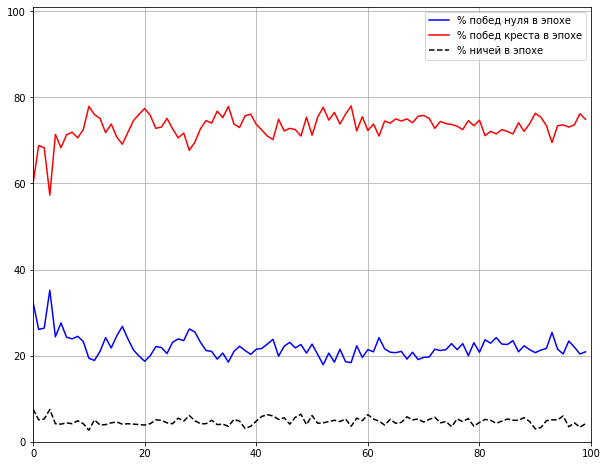

In [161]:
one_player = PlayerMediator(isZero=False, name="Pacardo_Machine_1")
zero_player = PlayerMediator(isZero=True, name="Pacardo_Machine_2")
fit(
    zero_player,
    one_player,
    epochs = 100,
    step_per_epoch = 1000,
    save_config = True,
    plot_win = True
)